In [15]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

In [4]:
seed = 2724

### Import data

In [5]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [6]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [8]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=2724)

### Use SHAP to explain the model on test data

In [9]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 99%|===================| 1480/1500 [01:05<00:00]        

This will allow us to see which variables are most important to predicting the outcome.

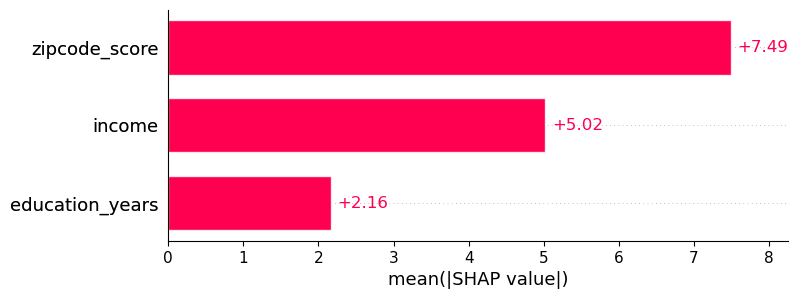

In [10]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [11]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [12]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

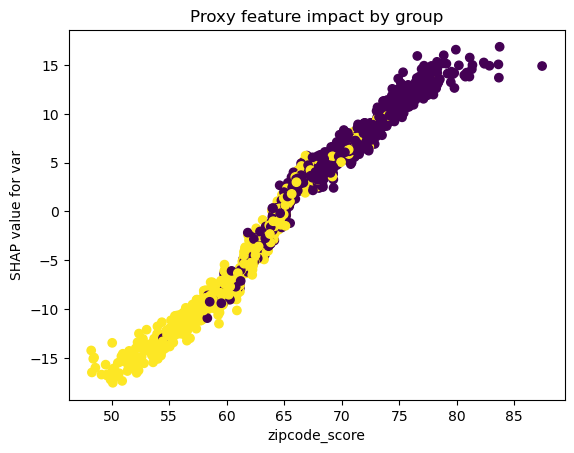

In [13]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

A SHAP (Shapley) value is a feature attribution method based on game theory that explains an individual prediction by calculating how much each feature contributed to the prediction relative to a baseline (average prediction). Each feature is treated as a “player” in a cooperative game, and the SHAP value represents its fair contribution to the final output, averaged over all possible combinations of features. This allows us to interpret both global feature importance and local prediction behavior.

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

No, the variable group was not used in training or prediction. The model was trained only using the features income, education_years, and zipcode_score. The group variable was introduced afterward strictly for auditing purposes to evaluate potential bias in the model’s predictions.

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Although group was not directly used in the model, the model’s outcomes may still be correlated with group due to proxy variables such as zipcode_score, income, or education_years. If these features are correlated with the protected demographic group, the model can indirectly produce different prediction patterns across groups. The group-level comparison of SHAP values suggests whether one group systematically receives higher or lower contributions from certain features, which indicates potential disparate impact.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

The income plot shows how the SHAP contribution of income changes as income increases and whether this effect differs between demographic groups. Compared to the zipcode_score plot, the income plot typically reflects a more direct economic relationship, where higher income increases predicted outcomes in a smoother pattern. In contrast, the zipcode_score plot often shows clearer separation between groups, suggesting it may act as a stronger proxy feature for demographic group membership. This indicates that location-based variables may introduce more bias than income alone.

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

Do model performance metrics (such as error rates or prediction accuracy) differ significantly across demographic groups?, Are any input features highly correlated with the protected variable group, indicating proxy discrimination risk?, Was any fairness metric (e.g., disparate impact ratio, equal opportunity, calibration across groups) evaluated before deployment?, Were any bias mitigation techniques considered, such as feature removal, reweighting, or fairness-aware training methods?